# Latest and best version!

ASSUMPTION: have bounding box with the target source and sink nodes, and assume that any paths leading out of this bounding box is unoptimal

## Importing everything

In [ ]:
!pip install osmnx folium geopandas networkx shapely matplotlib overpy

import osmnx as ox
print(f"OSMnx version: {ox.__version__}")

import logging
import os

# Set logging level
logging.basicConfig(level=logging.INFO)

# Configure OSMnx cache directory
cache_dir = os.path.expanduser("~/.osmnx_cache")
os.environ["OSMNX_CACHE"] = cache_dir
print(f"OSMnx cache directory: {cache_dir}")

# Step 1: Install necessary libraries
!pip install osmnx matplotlib networkx overpy folium

import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import overpy
import folium
import geopandas as gpd
from shapely.geometry import Point, LineString
import math
import pandas as pd
import random
import heapq


# Step 2: Configure OSMnx
#ox.config(use_cache=True, log_console=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 1.8 MB/s eta 0:00:00
OSMnx version: 2.0.0
OSMnx cache directory: /root/.osmnx_cache


## Functions

In [ ]:
# OSM data into geoJSON format
def nodes_to_geojson(result):
    features = []
    for node in result.nodes:
        lat, lon = float(node.lat), float(node.lon)  # Ensure lat/lon are floats
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [lon, lat]
            },
            "properties": node.tags
        }
        features.append(feature)
    return {"type": "FeatureCollection", "features": features}

# Function to convert Overpass ways to GeoJSON format (for lines/polylines)
def ways_to_geojson(result):
    features = []
    for way in result.ways:
        coordinates = []
        for node in way.nodes:
            coordinates.append([float(node.lon), float(node.lat)])  # Convert to float
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "LineString",
                "coordinates": coordinates
            },
            "properties": way.tags
        }
        features.append(feature)
    return {"type": "FeatureCollection", "features": features}

# gets the node coordinates
def get_node_coordinates(G, node):
    """
    Get the coordinates of a node in the graph.
    """
    return G.nodes[node]['coords']

# query to get bus stops within a certain bounding perimeter, according to the given
# distance parameter (in m) and point latitude/longitude
# the distance parameter is converted into latitude and longitude
def query_get_bus_stops(start, end):
  # Extract coordinates
  start_lon = start[0]
  start_lat = start[1]
  end_lon = end[0]
  end_lat = end[1]

  # Minimum and maximum coordinates
  min_lat = min(start_lat, end_lat)
  max_lat = max(start_lat, end_lat)
  min_lon = min(start_lon, end_lon)
  max_lon = max(start_lon, end_lon)

  query = f"""[out:json];
  node[network="TTC"][bus="yes"]({min_lat},{min_lon},{max_lat},{max_lon});
  out body;"""

  return query

# same idea for the bus routes as with the bus stops
def query_get_bus_routes(start, end):
  # Extract coordinates
  start_lon = start[0]
  start_lat = start[1]
  end_lon = end[0]
  end_lat = end[1]

  # Minimum and maximum coordinates
  min_lat = min(start_lat, end_lat)
  max_lat = max(start_lat, end_lat)
  min_lon = min(start_lon, end_lon)
  max_lon = max(start_lon, end_lon)

  query = f"""[out:json];
  relation["type"="route"]["route"="bus"]({min_lat},{min_lon},{max_lat},{max_lon});
  (._;>;);
  out geom;
  """

  return query

# a similar query to the one for bus stops, but for walking paths
def query_get_walking_paths(start, end):
    # Extract coordinates
    start_lon = start[0]
    start_lat = start[1]
    end_lon = end[0]
    end_lat = end[1]

    # Minimum and maximum coordinates
    min_lat = min(start_lat, end_lat)
    max_lat = max(start_lat, end_lat)
    min_lon = min(start_lon, end_lon)
    max_lon = max(start_lon, end_lon)

    # Construct the Overpass API query with the correct order
    query = f"""[out:json];
    way["highway"="footway"]({min_lat},{min_lon},{max_lat},{max_lon});
    (._;>;);
    out geom;"""

    # print(query)
    return query

# similar to the other queries too!
def query_get_bike_rental_stations(start, end):  #### keep if can figure out roads in Toronto

  # Extract coordinates
  start_lon = start[0]
  start_lat = start[1]
  end_lon = end[0]
  end_lat = end[1]

  # Minimum and maximum coordinates
  min_lat = min(start_lat, end_lat)
  max_lat = max(start_lat, end_lat)
  min_lon = min(start_lon, end_lon)
  max_lon = max(start_lon, end_lon)

  query = f"""[out:json];
  nwr["amenity"="bicycle_rental"]({min_lat},{min_lon},{max_lat},{max_lon});
  (._;>;);
  out geom;"""

  return query

# converts degrees to meters -- we have the Haverskine one, so we might not need this
def degrees_to_meters(degrees, latitude):
    """
    convert degrees to meters using the Haversine approximation.
    assumes the Earth is a sphere.

    parameters:
        degrees: Distance in degrees.
        latitude: Latitude of the location (in degrees), used for scaling.

    returns:
        distance in meters.
    """
    # approximation Earth radius in meters
    earth_radius = 6371000

    # convert degrees to radians
    degrees_in_radians = math.radians(degrees)

    # convert degrees along the latitude (consider Earth's curvature)
    distance_in_meters = degrees_in_radians * earth_radius * math.cos(math.radians(latitude))
    return distance_in_meters

# calculates the distance between 2 points (in metres)
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in meters
    R = 6371000

    # Convert latitude and longitude from degrees to radians
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    # Haversine formula
    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in meters
    distance = R * c
    return distance

# calculates the distance given a list of multiple points (in m)
def calculate_distances(coords_list):
    """
    Given a list of (latitude, longitude) tuples, calculate the total distance
    between consecutive points using the Haversine formula.

    :param coords_list: List of tuples where each tuple is (lat, lon).
    :return: List of distances between consecutive points.
    """
    distances = []

    for i in range(1, len(coords_list)):
        lat1, lon1 = coords_list[i-1]
        lat2, lon2 = coords_list[i]

        distance = haversine(lat1, lon1, lat2, lon2)
        distances.append(distance)

    return distances


def graph_G(G, with_labels=True):
  plt.figure(figsize=(10, 10))
  pos = {node: G.nodes[node]['coords'] for node in G.nodes}
  nx.draw(G, pos, with_labels=with_labels, node_size=50, font_size=8)
  plt.show()

def create_subway_graph(subway_stations_gdf, subway_routes_gdf):
    # Initialize graph
    G = nx.Graph()

    # Add subway stations as nodes
    station_coords = {}  # Map station names to coordinates
    for idx, row in subway_stations_gdf.iterrows():
        station_point = row['geometry']
        station_name = row['name']
        station_coords[station_name] = (station_point.x, station_point.y)
        G.add_node(station_name, coords=(station_point.x, station_point.y), type='subway_station')

    # Add edges based on subway routes
    for idx, row in subway_routes_gdf.iterrows():
        if isinstance(row['geometry'], LineString):
            coords = list(row['geometry'].coords)

            # Identify the nearest stations along the route
            for i in range(len(coords) - 1):
                start_coord = coords[i]
                end_coord = coords[i + 1]

                # Find the closest stations to the route points
                start_station = min(station_coords, key=lambda s: haversine_distance(station_coords[s], start_coord))
                end_station = min(station_coords, key=lambda s: haversine_distance(station_coords[s], end_coord))

                # Avoid duplicate or unnecessary edges
                if start_station != end_station:
                    distance = haversine_distance(station_coords[start_station], station_coords[end_station])
                    if not G.has_edge(start_station, end_station):
                        G.add_edge(start_station, end_station, weight=distance)

    # Print graph summary
    print(f"Graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges created.")
    return G

this is specifically for combining subway/bus routes with subway/bus stations into a single graph

In [ ]:
def haversine_distance(coord1, coord2):
    """
    Calculate the Haversine distance between two (lon, lat) points.
    """
    lon1, lat1 = math.radians(coord1[0]), math.radians(coord1[1])
    lon2, lat2 = math.radians(coord2[0]), math.radians(coord2[1])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    radius = 6371000  # Earth's radius in meters
    return radius * c

# proximity threshold is to connect bus stations that are in a 100 metre proximity to the subway station with an edge,
# so that we can connect subway and bus nodes together without over complicating the graph in ways we do not mean to
def create_graph_from_routes_and_stations(subway_stations_gdf, bus_stations_gdf, subway_routes_gdf, bus_routes_gdf, proximity_threshold=100):
    import networkx as nx
    from shapely.geometry import Point, LineString

    # Initialize graph
    G = nx.Graph()

    # Add subway stations as nodes
    subway_station_coords = {}
    for idx, row in subway_stations_gdf.iterrows():
        station_point = row['geometry']
        station_name = row['name']
        subway_station_coords[station_name] = (station_point.x, station_point.y)
        G.add_node(station_name, coords=(station_point.x, station_point.y), type='subway_station')

    # Add bus stations as nodes
    bus_station_coords = {}
    for idx, row in bus_stations_gdf.iterrows():
        station_point = row['geometry']
        station_name = row['name']
        bus_station_coords[station_name] = (station_point.x, station_point.y)
        G.add_node(station_name, coords=(station_point.x, station_point.y), type='bus_station')

    # Add edges between subway and bus stations based on proximity
    for bus_station, bus_coords in bus_station_coords.items():
        for subway_station, subway_coords in subway_station_coords.items():
            distance = haversine_distance(bus_coords, subway_coords)
            if distance <= proximity_threshold:
                # If distance is within the threshold, add an edge between the stations
                if not G.has_edge(bus_station, subway_station):
                    G.add_edge(bus_station, subway_station, weight=distance)

    # Add subway routes as edges
    for idx, row in subway_routes_gdf.iterrows():
        if isinstance(row['geometry'], LineString):
            coords = list(row['geometry'].coords)
            for i in range(len(coords) - 1):
                start_coord = coords[i]
                end_coord = coords[i + 1]

                # Find the closest subway stations to the route points
                start_station = min(subway_station_coords, key=lambda s: haversine_distance(subway_station_coords[s], start_coord))
                end_station = min(subway_station_coords, key=lambda s: haversine_distance(subway_station_coords[s], end_coord))

                # Add edge only between subway stations
                if start_station != end_station:
                    distance = haversine_distance(subway_station_coords[start_station], subway_station_coords[end_station])
                    if not G.has_edge(start_station, end_station):
                        G.add_edge(start_station, end_station, weight=distance)

    # Add bus routes as edges
    for idx, row in bus_routes_gdf.iterrows():
        if isinstance(row['geometry'], LineString):
            coords = list(row['geometry'].coords)
            for i in range(len(coords) - 1):
                start_coord = coords[i]
                end_coord = coords[i + 1]

                # Find the closest bus stations to the route points
                start_station = min(bus_station_coords, key=lambda s: haversine_distance(bus_station_coords[s], start_coord))
                end_station = min(bus_station_coords, key=lambda s: haversine_distance(bus_station_coords[s], end_coord))

                # Add edge only between bus stations
                if start_station != end_station:
                    distance = haversine_distance(bus_station_coords[start_station], bus_station_coords[end_station])
                    if not G.has_edge(start_station, end_station):
                        G.add_edge(start_station, end_station, weight=distance)

    # Print graph summary
    print(f"Graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges created.")
    return G

# # a star function to get shortest path - better than dijkstra's
# def astar(graph, start, goal):
#     import heapq

#     open_set = [(0, start)]  # Priority queue: (f_score, node)
#     came_from = {}  # To reconstruct the path
#     g_score = {node: float('inf') for node in graph.nodes}
#     g_score[start] = 0
#     f_score = {node: float('inf') for node in graph.nodes}
#     f_score[start] = haversine_distance(graph.nodes[start]['coords'], graph.nodes[goal]['coords'])

#     while open_set:
#         # Get node with lowest f_score
#         _, current = heapq.heappop(open_set)

#         print(f"Evaluating node: {current}")

#         # Check if we've reached the goal
#         if current == goal:
#             # Reconstruct and return the path
#             path = []
#             while current in came_from:
#                 path.append(current)
#                 current = came_from[current]
#             path.append(start)
#             print("Path found!")
#             return path[::-1]  # Reverse path to correct order

#         for neighbor in graph.neighbors(current):
#             print(neighbor)

#             # Distance between current and neighbor
#             tentative_g_score = g_score[current] + haversine_distance(
#                 graph.nodes[current]['coords'], graph.nodes[neighbor]['coords']
#             )
#             if tentative_g_score < g_score[neighbor]:
#                 # Update scores and path
#                 came_from[neighbor] = current
#                 g_score[neighbor] = tentative_g_score
#                 f_score[neighbor] = tentative_g_score + haversine_distance(
#                     graph.nodes[neighbor]['coords'], graph.nodes[goal]['coords']
#                 )
#                 heapq.heappush(open_set, (f_score[neighbor], neighbor))
#                 print(f"Neighbor {neighbor} updated with f_score {f_score[neighbor]}")

#     print("No path found.")
#     return None  # If no path is found

def astar(graph, start, goal):

    open_set = [(0, start)]  # Priority queue: (f_score, node)
    came_from = {}  # To reconstruct the path
    g_score = {node: float('inf') for node in graph.nodes}
    g_score[start] = 0
    f_score = {node: float('inf') for node in graph.nodes}
    f_score[start] = haversine_distance(graph.nodes[start]['coords'], graph.nodes[goal]['coords'])

    while open_set:
        # Get node with lowest f_score
        _, current = heapq.heappop(open_set)

        # print(f"Evaluating node: {current}")

        # Check if we've reached the goal
        if current == goal:
            # Reconstruct the path and calculate the total distance
            path = []
            total_distance = 0
            while current in came_from:
                path.append(current)
                total_distance += haversine_distance(
                    graph.nodes[current]['coords'], graph.nodes[came_from[current]]['coords']
                )
                current = came_from[current]
            path.append(start)
            # print("Path found!")
            # Reverse path to correct order
            return path[::-1], total_distance  # Path and total distance in meters

        for neighbor in graph.neighbors(current):
            # print(neighbor)

            # Distance between current and neighbor
            tentative_g_score = g_score[current] + haversine_distance(
                graph.nodes[current]['coords'], graph.nodes[neighbor]['coords']
            )
            if tentative_g_score < g_score[neighbor]:
                # Update scores and path
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + haversine_distance(
                    graph.nodes[neighbor]['coords'], graph.nodes[goal]['coords']
                )
                heapq.heappush(open_set, (f_score[neighbor], neighbor))
                # print(f"Neighbor {neighbor} updated with f_score {f_score[neighbor]}")

    # print("No path found.")
    return None, 0  # If no path is found, return None and distance 0


# a star function by proximity in the case that the bus stations aren't close to subway, but shouldn't be needed
# now that we are adding edges to connect subway and bus stations that are 100 metres away from each other.
def astar_with_proximity(graph, start, goal, proximity_threshold=50):
    import heapq

    open_set = [(0, start)]  # Priority queue: (f_score, node)
    came_from = {}  # To reconstruct the path
    g_score = {node: float('inf') for node in graph.nodes}
    g_score[start] = 0
    f_score = {node: float('inf') for node in graph.nodes}
    f_score[start] = haversine_distance(graph.nodes[start]['coords'], graph.nodes[goal]['coords'])

    while open_set:
        # Get node with lowest f_score
        _, current = heapq.heappop(open_set)

        # print(f"Evaluating node: {current}")

        # Check if current node is within the proximity threshold of the goal
        distance_to_goal = haversine_distance(graph.nodes[current]['coords'], graph.nodes[goal]['coords'])
        # print(f"Distance to goal from {current}: {distance_to_goal} meters")

        if distance_to_goal <= proximity_threshold:
            # Reconstruct and return the path
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            # print("Path found!")
            return path[::-1]  # Reverse path to correct order

        # print(graph.neighbors(current))
        for neighbor in graph.neighbors(current):
            # print(neighbor)

            # Distance between current and neighbor
            tentative_g_score = g_score[current] + haversine_distance(
                graph.nodes[current]['coords'], graph.nodes[neighbor]['coords']
            )
            if tentative_g_score <= g_score[neighbor]:
                # Update scores and path
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + haversine_distance(
                    graph.nodes[neighbor]['coords'], graph.nodes[goal]['coords']
                )
                heapq.heappush(open_set, (f_score[neighbor], neighbor))
                # print(f"Neighbor {neighbor} updated with f_score {f_score[neighbor]}")

    # print(came_from)
    # print("No path found.")
    return None  # If no path is found

this is specifically for combining subway stations with walking routes into one graph

In [ ]:
def create_graph_from_stations_and_paths(subway_stations_gdf, walking_paths_gdf, proximity_threshold=50):
    """
    Creates a directed graph (DiGraph) where nodes are subway stations,
    the start and end points of walking paths, and edges represent walking paths.

    Parameters:
        subway_stations_gdf (GeoDataFrame): GeoDataFrame containing Point geometries of subway stations.
        walking_paths_gdf (GeoDataFrame): GeoDataFrame containing LineString geometries of walking paths.
        proximity_threshold (float): Distance threshold in meters to connect paths to stations.

    Returns:
        nx.DiGraph: Directed graph where nodes are subway stations and walking path endpoints,
                    and edges represent walking paths.
    """

    # Initialize the directed graph
    G = nx.DiGraph()

    # Add subway stations as nodes
    subway_station_coords = {}
    for idx, row in subway_stations_gdf.iterrows():
        station_point = row['geometry']
        station_name = row['name']
        subway_station_coords[station_name] = (station_point.x, station_point.y)
        G.add_node(station_name, coords=(station_point.x, station_point.y), type='subway_station')

    # Add nodes and edges for walking paths
    for idx, row in walking_paths_gdf.iterrows():
        if row['geometry'].geom_type == 'LineString':
            path_coords = list(row['geometry'].coords)

            # Start and end points of the LineString
            start_coord = path_coords[0]
            end_coord = path_coords[-1]

            # Add start and end points as nodes
            start_node = f"start_{idx}"
            end_node = f"end_{idx}"
            G.add_node(start_node, coords=start_coord, type='path_endpoint')
            G.add_node(end_node, coords=end_coord, type='path_endpoint')

            # Add edge between start and end nodes for the LineString
            G.add_edge(start_node, end_node, weight=row['geometry'].length, geometry=row['geometry'])

            # Find the closest subway stations to the start and end points
            start_station = min(subway_station_coords, key=lambda s: haversine_distance(subway_station_coords[s], start_coord))
            end_station = min(subway_station_coords, key=lambda s: haversine_distance(subway_station_coords[s], end_coord))

            # Connect start point to a subway station if within the proximity threshold
            start_distance = haversine_distance(subway_station_coords[start_station], start_coord)
            if start_distance <= proximity_threshold:
                G.add_edge(start_station, start_node, weight=start_distance)

            # Connect end point to a subway station if within the proximity threshold
            end_distance = haversine_distance(subway_station_coords[end_station], end_coord)
            if end_distance <= proximity_threshold:
                G.add_edge(end_node, end_station, weight=end_distance)

    # Print graph summary
    # print(f"Directed graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges created.")
    return G


## Queries & Forming GDFs

Edit the code here to set different starting and ending points when testing out the shortest path algorithms.

In [ ]:
# select coordinates for the specific locations to test
start_station = 'Spadina'
end_station = 'St. Patrick'

In [ ]:
api = overpy.Overpass()

# Function to fetch GeoDataFrame from Overpass query
# ive got the routes of subways and buses and their corresponding stations in respective gdfs

# function to get the subway route in Toronto - since these don't overload the system, we don't need bounding boxes
query_sub_line = """[out:json];
relation["type"="route"]["route"="subway"](43.5810,-79.6393,43.8555,-79.1168);
(._;>;);
out geom;"""

# Second query - TTC subway stations
query_sub_stations = """[out:json];
node[network="TTC"][subway="yes"];
out body;"""

##### QUERY 1: this gets the TTC subway route
result_sub_line = api.query(query_sub_line)
geojson_sub_line = ways_to_geojson(result_sub_line)
gdf_sub_line = gpd.GeoDataFrame.from_features(geojson_sub_line['features'])

##### QUERY 2: this gets the TTC subway stations
result_sub_stations = api.query(query_sub_stations)
geojson_sub_stations = nodes_to_geojson(result_sub_stations)
gdf_sub_stations = gpd.GeoDataFrame.from_features(geojson_sub_stations['features'])

##### this creates a subway graph as we'll also refer to this later on, in order to gather
##### information about the coordinates for the bounding boxes of the other queries
G_stations = create_subway_graph(gdf_sub_stations, gdf_sub_line)

start_coords = get_node_coordinates(G_stations, start_station)
end_coords = get_node_coordinates(G_stations, end_station)

##### QUERY 3: this gets the bus routes
query_bus_routes = query_get_bus_routes(start_coords, end_coords)
result_bus_routes = api.query(query_bus_routes)
geojson_bus_routes = ways_to_geojson(result_bus_routes)
gdf_bus_routes = gpd.GeoDataFrame.from_features(geojson_bus_routes['features'])

##### QUERY 4: this gets the bus stops
query_bus_stations = query_get_bus_stops(start_coords, end_coords)
result_bus_stations = api.query(query_bus_stations)
geojson_bus_stations = nodes_to_geojson(result_bus_stations)
gdf_bus_stations = gpd.GeoDataFrame.from_features(geojson_bus_stations['features'])

##### QUERY 5: this gets the walking paths
query_walking_paths = query_get_walking_paths(start_coords, end_coords)
result_walking_paths = api.query(query_walking_paths)
geojson_walking_paths = ways_to_geojson(result_walking_paths)
gdf_walking_paths = gpd.GeoDataFrame.from_features(geojson_walking_paths['features'])

Graph with 55 nodes and 55 edges created.


## Getting shortest path (just subway route)

Graph with 55 nodes and 55 edges created.


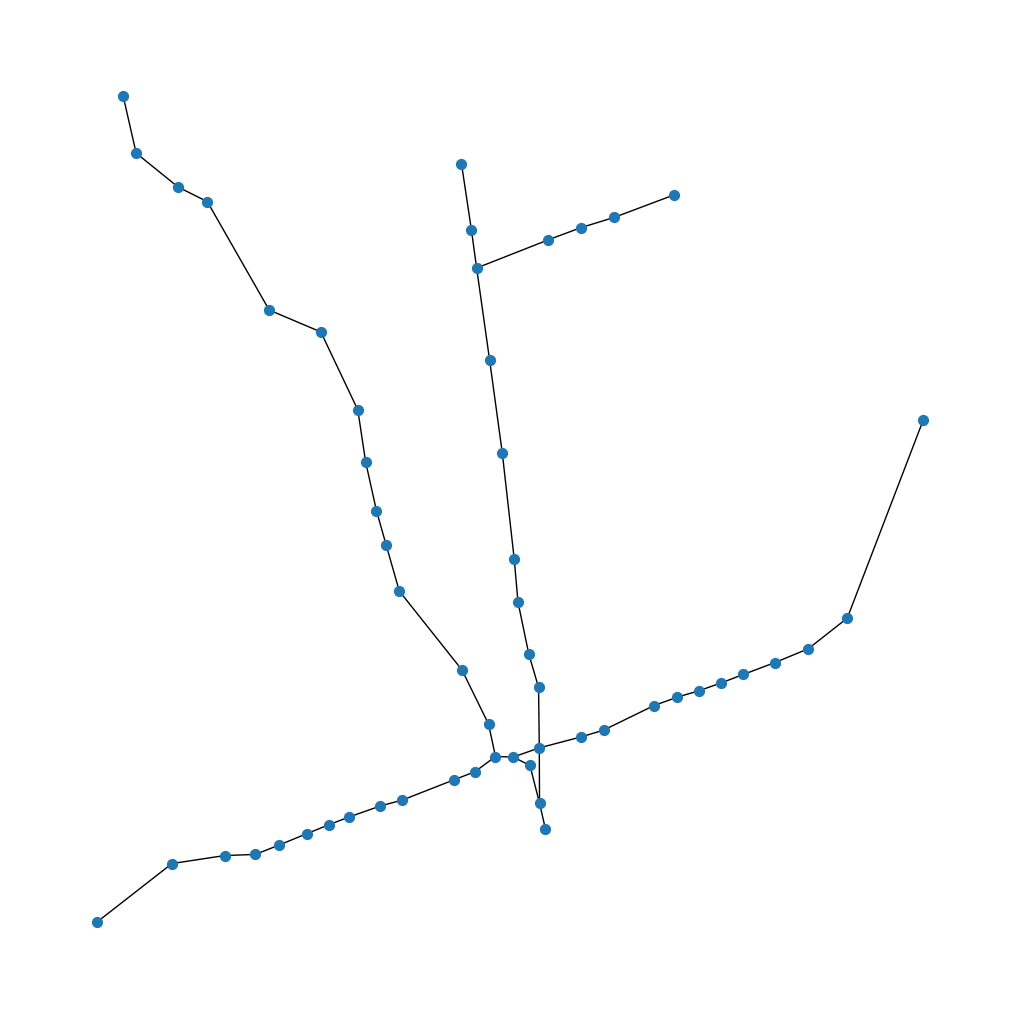

In [ ]:
# graph of subway
G_stations = create_subway_graph(gdf_sub_stations, gdf_sub_line)

# prints out the graph
graph_G(G_stations, with_labels=False)

In [ ]:
# gets the shortest path of the subway

subway_shortest = nx.shortest_path(G_stations, start_station, end_station, weight='weight', method='dijkstra')
print(subway_shortest) # prints out the nodes that form the shortest path

['Museum', "Queen's Park", 'St. Patrick']


plots the shortest path on a Folium map

In [ ]:
# Center of Toronto
toronto_center = [43.7, -79.4]

# Initialize the map
m = folium.Map(location=toronto_center, zoom_start=12)

loc = []

# Assuming subway_shortest is a list of nodes (station names or ids)
for coord in subway_shortest:
    node_coord = get_node_coordinates(G_stations, coord)

    # Debug: Print coordinates
    print(f"Node {coord} has coordinates {node_coord}")

    # Add a marker for each coordinate
    folium.Marker(location=(node_coord[1], node_coord[0]), popup=f"Point: {coord}").add_to(m)

    # Collect coordinates for the polyline
    loc.append((node_coord[1], node_coord[0]))  # Ensure lat, long order

# Add a line connecting the points
folium.PolyLine(locations=loc, color="red", weight=2.5).add_to(m)

m

Node Museum has coordinates (-79.3933506, 43.6668462)
Node Queen's Park has coordinates (-79.3901923, 43.6596838)
Node St. Patrick has coordinates (-79.3882736, 43.6548199)


## Getting shortest path (subway and bus)

Graph with 66 nodes and 71 edges created.


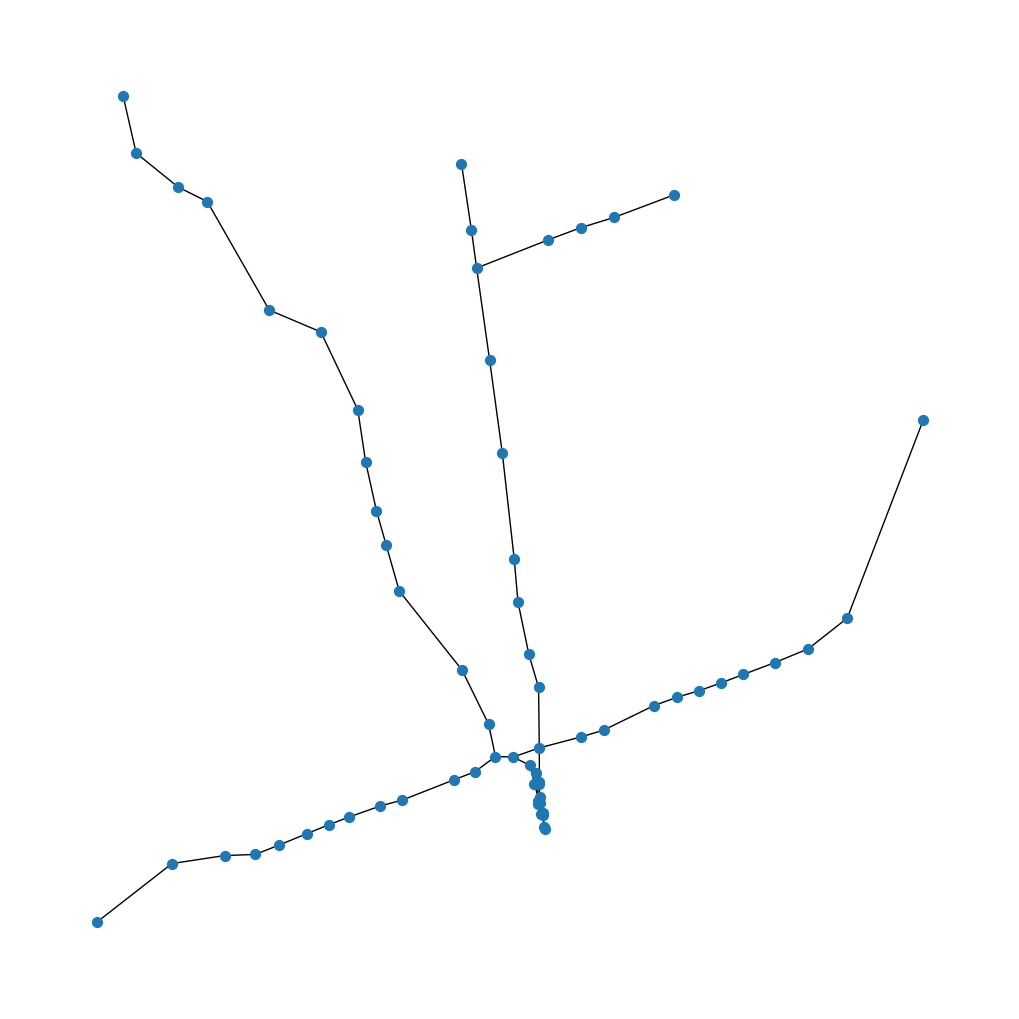

In [ ]:
# makes a graph that has its nodes based on the subway/bus stations and its edges based on the corresponding routes
combo_G = create_graph_from_routes_and_stations(gdf_sub_stations, gdf_bus_stations, gdf_sub_line, gdf_bus_routes)

# makes the graph
graph_G(combo_G, with_labels=False)

In [ ]:
# calculates the shortest path based on the starting and ending points set earlier
shortest_path, total_distance = astar(combo_G, start_station, end_station)
print(shortest_path)
print("Distance:", total_distance, "meters")

['Museum', "Queen's Park", 'St. Patrick']
Distance: 1398.3974465756396 meters


## Getting shortest path (subway and walking routes)

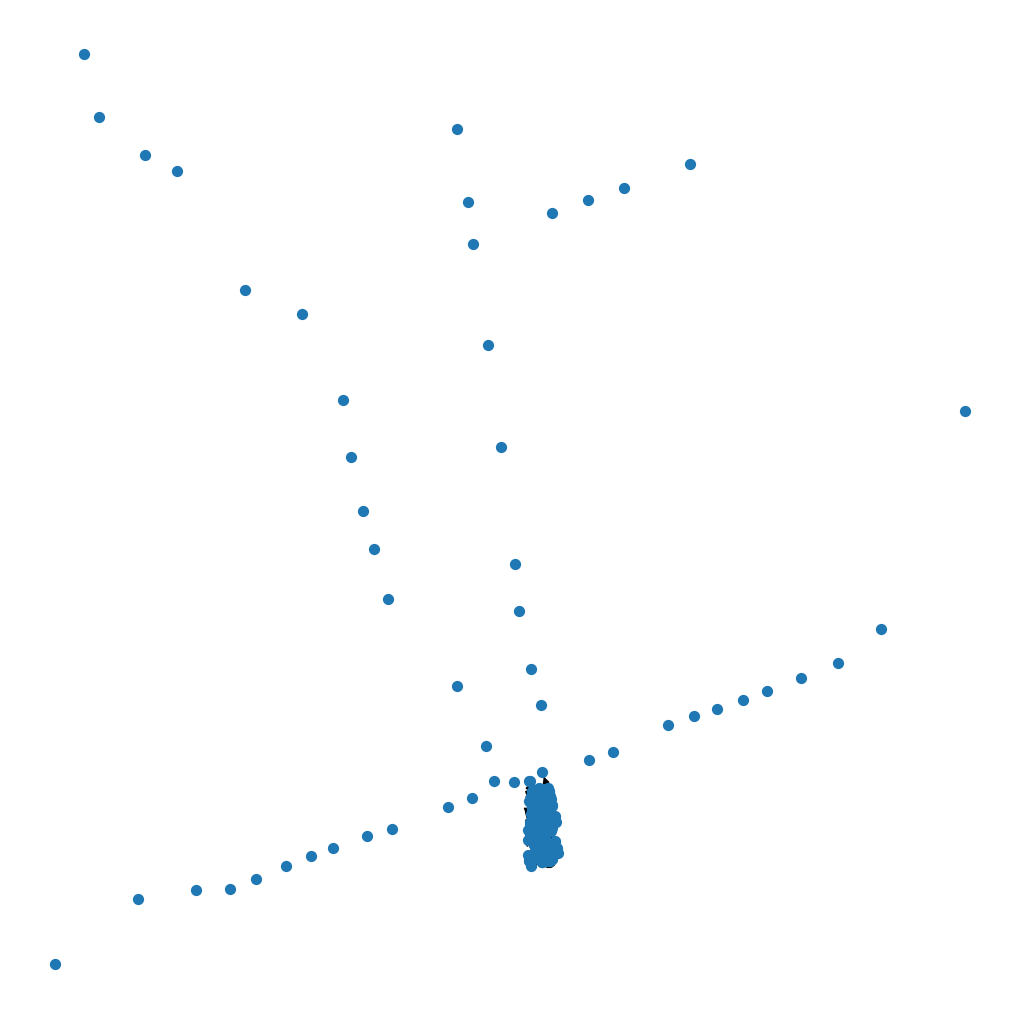

In [ ]:
combo_G_sub_walk = create_graph_from_stations_and_paths(gdf_sub_stations, gdf_walking_paths, proximity_threshold=500)
graph_G(combo_G_sub_walk, with_labels=False)

In [ ]:
# calculates the shortest path based on the starting and ending points set earlier
shortest_path, total_distance = astar(combo_G_sub_walk, start_station, end_station)
print(shortest_path)
print("Distance:", total_distance, "meters")

['Museum', 'start_180', 'end_180', "Queen's Park", 'start_426', 'end_426', 'St. Patrick']
Distance: 1426.8816835499333 meters


In [ ]:
# Center of Toronto
toronto_center = [43.7, -79.4]

# Initialize the map
m = folium.Map(location=toronto_center, zoom_start=12)

loc = []

# Assuming subway_shortest is a list of nodes (station names or ids)
for coord in shortest_path:
    node_coord = get_node_coordinates(combo_G_sub_walk, coord)

    # Debug: Print coordinates
    print(f"Node {coord} has coordinates {node_coord}")

    # Add a marker for each coordinate
    folium.Marker(location=(node_coord[1], node_coord[0]), popup=f"Point: {coord}").add_to(m)

    # Collect coordinates for the polyline
    loc.append((node_coord[1], node_coord[0]))  # Ensure lat, long order

# Add a line connecting the points
folium.PolyLine(locations=loc, color="red", weight=2.5).add_to(m)

m

Node Museum has coordinates (-79.3933506, 43.6668462)
Node start_180 has coordinates (-79.3908701, 43.6634746)
Node end_180 has coordinates (-79.3905428, 43.6620175)
Node Queen's Park has coordinates (-79.3901923, 43.6596838)
Node start_426 has coordinates (-79.3890901, 43.6572923)
Node end_426 has coordinates (-79.3886891, 43.6571422)
Node St. Patrick has coordinates (-79.3882736, 43.6548199)


## Getting the amount of time ....

average walking speed: 2 miles per hour baseline (https://www.healthline.com/health/exercise-fitness/average-walking-speed#tips-to-get-started)

this is equal to


In [ ]:
ave_walk_speed = 2 # miles per hour
ave_walk_speed_km = ave_walk_speed * 1.60934 # km per hour
print(f"ave walking speed: {ave_walk_speed_km} km/h")

time = (total_distance/1000) / ave_walk_speed_km
print(f"{time} h or {time*60} min")

ave walking speed: 3.21868 km/h
0.4433126882914528 h or 26.59876129748717 min


## Subway stations in the graph

In [ ]:
G_stations.nodes()

NodeView(('Bathurst', 'Bay', 'Dundas West', 'St. Patrick', 'Main Street', 'Pape', 'Coxwell', 'Woodbine', 'St. George', 'Wilson', 'St. Clair', 'Eglinton', 'Lawrence', 'York Mills', 'Finch', 'Old Mill', 'Kipling', 'North York Centre', 'Donlands', 'Greenwood', 'Summerhill', "Queen's Park", 'Sherbourne', 'Sheppard West', 'Keele', 'High Park', 'Glencairn', 'Runnymede', 'Jane', 'Castle Frank', 'Kennedy', 'Vaughan Metropolitan Centre', 'Downsview Park', 'Christie', 'Sheppard-Yonge', 'Bayview', 'Bessarion', 'Don Mills', 'Leslie', 'Davisville', 'Spadina', 'Museum', 'St. Clair West', 'Dupont', 'Eglinton West', 'Yorkdale', 'Lawrence West', 'Pioneer Village', 'York University', 'Highway 407', 'Royal York', 'Lansdowne', 'Dufferin', 'Victoria Park', 'Chester'))

# Optimization function

In [ ]:
def optimize_walking_path_distance_time(start_station, end_station, proximity_threshold = 0):

  api = overpy.Overpass()

  # Function to fetch GeoDataFrame from Overpass query
  # ive got the routes of subways and buses and their corresponding stations in respective gdfs

  # function to get the subway route in Toronto - since these don't overload the system, we don't need bounding boxes
  query_sub_line = """[out:json];
  relation["type"="route"]["route"="subway"](43.5810,-79.6393,43.8555,-79.1168);
  (._;>;);
  out geom;"""

  # Second query - TTC subway stations
  query_sub_stations = """[out:json];
  node[network="TTC"][subway="yes"];
  out body;"""

  ##### QUERY 1: this gets the TTC subway route
  result_sub_line = api.query(query_sub_line)
  geojson_sub_line = ways_to_geojson(result_sub_line)
  gdf_sub_line = gpd.GeoDataFrame.from_features(geojson_sub_line['features'])

  ##### QUERY 2: this gets the TTC subway stations
  result_sub_stations = api.query(query_sub_stations)
  geojson_sub_stations = nodes_to_geojson(result_sub_stations)
  gdf_sub_stations = gpd.GeoDataFrame.from_features(geojson_sub_stations['features'])

  # get the coordinates for the subway stations we are starting/ending at
  start_coords = get_node_coordinates(G_stations, start_station)
  end_coords = get_node_coordinates(G_stations, end_station)

  ##### QUERY 3: this gets the walking paths
  query_walking_paths = query_get_walking_paths(start_coords, end_coords)
  result_walking_paths = api.query(query_walking_paths)
  geojson_walking_paths = ways_to_geojson(result_walking_paths)
  gdf_walking_paths = gpd.GeoDataFrame.from_features(geojson_walking_paths['features'])

  G_nodes = []
  G_edges = []

  # loops until a proximity threshold to the subway station from a walking route node is found such that
  # a shortest path that is not None is returned or if the Graph's nodes and edges stays the same for at least
  # 10 times, then the Graph is unlikely to find a path and we return None and print out "No path found!"
  while(True):
    combo_G = create_graph_from_stations_and_paths(gdf_sub_stations, gdf_walking_paths, proximity_threshold)

    shortest_path, total_distance = astar(combo_G, start_station, end_station)
    # print(shortest_path)
    if shortest_path != None:
      # print(shortest_path)
      # print("Distance:", total_distance, "meters")
      break
    elif shortest_path == None:
      proximity_threshold += 50
      G_nodes.append(combo_G.number_of_nodes())
      G_edges.append(combo_G.number_of_edges())
      # print(G_nodes)
      # print(G_edges)

    if G_nodes.count(combo_G.number_of_nodes()) > 10 and G_edges.count(combo_G.number_of_edges()) > 10:
      # print("No path possible!")
      return None, None, None, None, None
      break

  ave_walk_speed = 2 # miles per hour
  ave_walk_speed_km = ave_walk_speed * 1.60934 # km per hour
  # print(f"ave walking speed: {ave_walk_speed_km} km/h")

  time = (total_distance/1000) / ave_walk_speed_km
  # print(f"{time} h or {time*60} min")

  if time < 1:
    time = time * 60
    time_unit = "min"
  else:
    time_unit = "h"

  # shortest path is a list of nodes, total_distance is in metres, time is in hours
  return shortest_path, total_distance, time, time_unit, combo_G



In [ ]:
shortest_path, total_distance, time, time_unit, combo_G = optimize_walking_path_distance_time('Museum', 'St. Patrick', proximity_threshold = 0)
if shortest_path != None:
  print(f"\n\nShortest path: {shortest_path}\nTotal distance: {total_distance/1000}km\nTime: {time}{time_unit}")

['Museum', 'start_180', 'end_180', "Queen's Park", 'start_426', 'end_426', 'St. Patrick']


Shortest path: ['Museum', 'start_180', 'end_180', "Queen's Park", 'start_426', 'end_426', 'St. Patrick']
Total distance: 1.4268816835499334km
Time: 26.59876129748717min


In [ ]:
# Center of Toronto
toronto_center = [43.7, -79.4]

# Initialize the map
m = folium.Map(location=toronto_center, zoom_start=12)

loc = []

# Assuming subway_shortest is a list of nodes (station names or ids)
for coord in shortest_path:
    node_coord = get_node_coordinates(combo_G, coord)

    # Debug: Print coordinates
    # print(f"Node {coord} has coordinates {node_coord}")

    # Add a marker for each coordinate
    folium.Marker(location=(node_coord[1], node_coord[0]), popup=f"Point: {coord}").add_to(m)

    # Collect coordinates for the polyline
    loc.append((node_coord[1], node_coord[0]))  # Ensure lat, long order

# Add a line connecting the points
folium.PolyLine(locations=loc, color="red", weight=2.5).add_to(m)

m

## Testing the optimization function

In [ ]:
subway_station_nodes = ['Bathurst', 'Bay', 'Dundas West', 'St. Patrick', 'Main Street', 'Pape', 'Coxwell', 'Woodbine', 'St. George', 'Wilson', 'St. Clair', 'Eglinton', 'Lawrence', 'York Mills', 'Finch', 'Old Mill', 'Kipling', 'North York Centre', 'Donlands', 'Greenwood', 'Summerhill', "Queen's Park", 'Sherbourne', 'Sheppard West', 'Keele', 'High Park', 'Glencairn', 'Runnymede', 'Jane', 'Castle Frank', 'Kennedy', 'Vaughan Metropolitan Centre', 'Downsview Park', 'Christie', 'Sheppard-Yonge', 'Bayview', 'Bessarion', 'Don Mills', 'Leslie', 'Davisville', 'Spadina', 'Museum', 'St. Clair West', 'Dupont', 'Eglinton West', 'Yorkdale', 'Lawrence West', 'Pioneer Village', 'York University', 'Highway 407', 'Royal York', 'Lansdowne', 'Dufferin', 'Victoria Park', 'Chester']
tracker = {}

for i in subway_station_nodes:
  for j in subway_station_nodes:
    if i != j:
      shortest_path, total_distance, time, time_unit, combo_G = optimize_walking_path_distance_time(i, j, proximity_threshold = 0)
      tracker[(i,j)] = (shortest_path, total_distance, time, time_unit, combo_G)
      if shortest_path != None:
        print(f"({i},{j}):  Shortest path: {shortest_path} \t  Total distance: {total_distance/1000}km \t  Time: {time}{time_unit}")
      else:
        print(f"({i},{j}):  No path found!")



(Bathurst,Bay):  No path found!
(Bathurst,Dundas West):  No path found!
(Bathurst,St. Patrick):  No path found!
(Bathurst,Main Street):  No path found!
(Bathurst,Pape):  No path found!
(Bathurst,Coxwell):  No path found!
(Bathurst,Woodbine):  No path found!
(Bathurst,St. George):  No path found!
(Bathurst,Wilson):  No path found!
(Bathurst,St. Clair):  No path found!
(Bathurst,Eglinton):  No path found!
(Bathurst,Lawrence):  No path found!
(Bathurst,York Mills):  No path found!
(Bathurst,Finch):  No path found!
(Bathurst,Old Mill):  No path found!
(Bathurst,Kipling):  No path found!
(Bathurst,North York Centre):  No path found!
(Bathurst,Donlands):  No path found!
(Bathurst,Greenwood):  No path found!
(Bathurst,Summerhill):  No path found!
(Bathurst,Queen's Park):  No path found!
(Bathurst,Sherbourne):  No path found!
(Bathurst,Sheppard West):  No path found!
(Bathurst,Keele):  No path found!
(Bathurst,High Park):  No path found!
(Bathurst,Glencairn):  No path found!
(Bathurst,Runnymed

KeyboardInterrupt: 

In [ ]:
for key, value in tracker.items():
    print(f"{key}: \t  Shortest path: {value[0]} \t  Total distance: {value[1]/1000}km \t  Time: {value[2]}{value[3]}")

## Selective testing

In [ ]:
subway_station_nodes = ['Bathurst', 'Bay', 'Dundas West', 'St. Patrick', 'Main Street', 'Pape', 'Coxwell', 'Woodbine', 'St. George', 'Wilson', 'St. Clair', 'Eglinton', 'Lawrence', 'York Mills', 'Finch', 'Old Mill', 'Kipling', 'North York Centre', 'Donlands', 'Greenwood', 'Summerhill', "Queen's Park", 'Sherbourne', 'Sheppard West', 'Keele', 'High Park', 'Glencairn', 'Runnymede', 'Jane', 'Castle Frank', 'Kennedy', 'Vaughan Metropolitan Centre', 'Downsview Park', 'Christie', 'Sheppard-Yonge', 'Bayview', 'Bessarion', 'Don Mills', 'Leslie', 'Davisville', 'Spadina', 'Museum', 'St. Clair West', 'Dupont', 'Eglinton West', 'Yorkdale', 'Lawrence West', 'Pioneer Village', 'York University', 'Highway 407', 'Royal York', 'Lansdowne', 'Dufferin', 'Victoria Park', 'Chester']
tracker = {}

i = 'Spadina'

for j in subway_station_nodes:
  if j != 'Spadina':
    shortest_path, total_distance, time, time_unit, combo_G = optimize_walking_path_distance_time('Museum', j, proximity_threshold = 0)
    tracker[(i,j)] = (shortest_path, total_distance, time, time_unit, combo_G)
    if shortest_path != None:
      print(f"({i},{j}):  Shortest path: {shortest_path} \t  Total distance: {total_distance/1000}km \t  Time: {time}{time_unit}")
    else:
      print(f"({i},{j}):  No path found!")

(Spadina,Bathurst):  No path found!
(Spadina,Bay):  Shortest path: ['Museum', 'start_72', 'end_72', 'Bay'] 	  Total distance: 0.4668943456003832km 	  Time: 8.703462517560924min
(Spadina,Dundas West):  Shortest path: ['Museum', 'start_76', 'end_76', 'St. George', 'start_109', 'end_109', 'Bathurst', 'start_1424', 'end_1424', 'Christie', 'start_712', 'end_712', 'Dufferin', 'start_687', 'end_687', 'Lansdowne', 'start_423', 'end_423', 'Dundas West'] 	  Total distance: 6.2050659112855024km 	  Time: 1.9278293931939499h
(Spadina,St. Patrick):  Shortest path: ['Museum', 'start_180', 'end_180', "Queen's Park", 'start_426', 'end_426', 'St. Patrick'] 	  Total distance: 1.4268816835499334km 	  Time: 26.59876129748717min
(Spadina,Main Street):  Shortest path: ['Museum', 'start_4206', 'end_4206', 'Bay', 'start_3771', 'end_3771', 'Sherbourne', 'start_158', 'end_158', 'Castle Frank', 'start_491', 'end_491', 'Chester', 'start_1737', 'end_1737', 'Pape', 'start_957', 'end_957', 'Donlands', 'start_232', 'e

In [ ]:
# print dictionary as dataframe
# Convert to DataFrame
df = pd.DataFrame.from_dict(
    tracker,
    orient="index",
    columns=["Shortest Path", "Total Distance", "Time", "Time Unit", "Combo_G"]
)

# Reset the index to move `(i, j)` keys into columns
df.reset_index(inplace=True)
df.rename(columns={"index": "Start-End"}, inplace=True)

# Print the DataFrame
df

,Start-End,Shortest Path,Total Distance,Time,Time Unit,Combo_G
0,"(Spadina, Bathurst)",None,NaN,NaN,None,None
1,"(Spadina, Bay)","[Museum, start_72, end_72, Bay]",466.894346,8.703463,min,"(Bathurst, Bay, Dundas West, St. Patrick, Main..."
2,"(Spadina, Dundas West)","[Museum, start_76, end_76, St. George, start_1...",6205.065911,1.927829,h,"(Bathurst, Bay, Dundas West, St. Patrick, Main..."
3,"(Spadina, St. Patrick)","[Museum, start_180, end_180, Queen's Park, sta...",1426.881684,26.598761,min,"(Bathurst, Bay, Dundas West, St. Patrick, Main..."
4,"(Spadina, Main Street)","[Museum, start_4206, end_4206, Bay, start_3771...",8106.972523,2.518726,h,"(Bathurst, Bay, Dundas West, St. Patrick, Main..."
5,"(Spadina, Pape)","[Museum, start_1625, end_1625, Bay, start_1539...",4429.893192,1.376307,h,"(Bathurst, Bay, Dundas West, St. Patrick, Main..."
6,"(Spadina, Coxwell)","[Museum, start_2740, end_2740, Bay, start_2582...",6297.930414,1.956681,h,"(Bathurst, Bay, Dundas West, St. Patrick, Main..."
7,"(Spadina, Woodbine)","[Museum, start_3406, end_3406, Bay, start_3159...",7173.154405,2.228601,h,"(Bathurst, Bay, Dundas West, St. Patrick, Main..."
8,"(Spadina, St. George)","[Museum, start_17, end_17, St. George]",500.310826,9.326385,min,"(Bathurst, Bay, Dundas West, St. Patrick, Main..."
9,"(Spadina, Wilson)","[Museum, start_1250, end_1250, St. George, sta...",10498.651080,3.261788,h,"(Bathurst, Bay, Dundas West, St. Patrick, Main..."


In [ ]:
# Write to CSV
csv_file_path = "spadina.csv"  # Specify your desired file path
df.to_csv(csv_file_path, index=True)  # Save without the index

# Conclusions

I think some possible issues with this rectangular bounding box is that when stations are in a straight line with each other, the bounding box has a hard time grabbing that particular data as it might be inline with the other point and causing information loss. Thus, it is difficult to retrieve a path.
* Bathurst and any other station results in no paths found
* Bay and any other station also results in no paths found

May need to manually try different stations to find paths that do work.

Using a circular bounding border results in more information retrieved, causing the information retrieval to be slower and more expensive. Not recommended.

Can consider not calculating for stations with large distances between them, as with the current walking routes, it is highly unlikely that there will be a possible path.

Current stations that work include the following:
* ```('Museum', 'St. Patrick')```
*